In [1]:
!pip3 install lightning einops

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms
import pytorch_lightning as pl
from torchmetrics import Accuracy, F1Score, Precision, Recall
from torch.optim import Adam
from sklearn.model_selection import train_test_split
import numpy as np
from einops.layers.torch import Rearrange
from einops import repeat

In [3]:
# Check if GPU is available
import torch
gpu_available = torch.cuda.is_available()
print("GPU Available:", gpu_available)

import multiprocessing

num_cores = multiprocessing.cpu_count()
print(f"Number of available CPU cores: {num_cores}")

GPU Available: True
Number of available CPU cores: 8


In [4]:
class FashionMNISTDataModule(pl.LightningDataModule):
    def __init__(self, batch_size=64):
        super().__init__()
        self.batch_size = batch_size
        self.transform = transforms.Compose([
            transforms.ToTensor(),  # This will normalize the values to [0, 1]
        ])

    def prepare_data(self):
        # Download datasets
        datasets.FashionMNIST(root='', train=True, download=True)
        datasets.FashionMNIST(root='', train=False, download=True)

    def setup(self, stage=None):
        # Load data
        full_train_dataset = datasets.FashionMNIST(root='', train=True, transform=self.transform)
        train_idx, val_idx = train_test_split(
            range(len(full_train_dataset)),
            test_size=0.1,
            shuffle=True,
            stratify=full_train_dataset.targets
        )
        
        self.train_dataset = Subset(full_train_dataset, train_idx)
        self.val_dataset = Subset(full_train_dataset, val_idx)
        self.test_dataset = datasets.FashionMNIST(root='', train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=8, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=8, pin_memory=True)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=8, pin_memory=True)

In [5]:
from pytorch_lightning import Callback
import time

class MetricsCallback(Callback):
    def __init__(self):
        super().__init__()
        self.reset_metrics()

    def reset_metrics(self):
        self.train_losses = []
        self.val_losses = []
        self.train_acc = []
        self.val_acc = []
        self.train_f1 = []
        self.val_f1 = []
        self.train_precision = []
        self.val_precision = []
        self.train_recall = []
        self.val_recall = []

    def on_train_epoch_end(self, trainer, pl_module):
        self.train_losses.append(trainer.callback_metrics['train_loss'].item())
        self.train_acc.append(trainer.callback_metrics['train_acc'].item())
        self.train_f1.append(trainer.callback_metrics['train_f1'].item())
        self.train_precision.append(trainer.callback_metrics['train_precision'].item())
        self.train_recall.append(trainer.callback_metrics['train_recall'].item())

    def on_validation_epoch_end(self, trainer, pl_module):
        self.val_losses.append(trainer.callback_metrics['val_loss'].item())
        self.val_acc.append(trainer.callback_metrics['val_acc'].item())
        self.val_f1.append(trainer.callback_metrics['val_f1'].item())
        self.val_precision.append(trainer.callback_metrics['val_precision'].item())
        self.val_recall.append(trainer.callback_metrics['val_recall'].item())

    def get_metrics(self):
        return {
            "train_losses": self.train_losses,
            "val_losses": self.val_losses,
            "train_acc": self.train_acc,
            "val_acc": self.val_acc,
            "train_f1": self.train_f1,
            "val_f1": self.val_f1,
            "train_precision": self.train_precision,
            "val_precision": self.val_precision,
            "train_recall": self.train_recall,
            "val_recall": self.val_recall,
        }

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")


def model_monitor(train_losses, val_losses, train_acc, val_acc, train_f1, val_f1, train_precision, val_precision, train_recall, val_recall):
    red    = '#FF6347'
    orange = "orange"
    blue   = '#4682B4'
    green  = "#55A868"
    purple = "#800080"
    cyan   = "#00FFFF"

    fig, ax = plt.subplots(2, 2, figsize=(20, 12))
    
    # Loss
    sns.lineplot(x=range(1, len(train_losses) + 1), y=train_losses, label='Train Loss', color=blue, ax=ax[0, 0])
    sns.lineplot(x=range(1, len(val_losses) + 1), y=val_losses, label='Validation Loss', color=green, ax=ax[0, 0])
    ax[0, 0].set_title('Training vs. Validation Loss', fontsize=16, fontweight='bold')
    ax[0, 0].set_xlabel('Epochs', fontsize=12, fontweight='bold')
    ax[0, 0].set_ylabel('Loss', fontsize=12, fontweight='bold')
    ax[0, 0].legend(facecolor='white', fontsize=12, title_fontsize='11', edgecolor='black')
    ax[0, 0].grid(True)

    # Accuracy
    sns.lineplot(x=range(1, len(train_acc) + 1), y=train_acc, label='Train Accuracy', color=orange, ax=ax[0, 1])
    sns.lineplot(x=range(1, len(val_acc) + 1), y=val_acc, label='Validation Accuracy', color=purple, ax=ax[0, 1])
    ax[0, 1].set_title('Training vs. Validation Accuracy', fontsize=16, fontweight='bold')
    ax[0, 1].set_xlabel('Epochs', fontsize=12, fontweight='bold')
    ax[0, 1].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax[0, 1].legend(facecolor='white', fontsize=12, title_fontsize='11', edgecolor='black')
    ax[0, 1].grid(True)

    # F1 Score
    sns.lineplot(x=range(1, len(train_f1) + 1), y=train_f1, label='Train F1 Score', color=cyan, ax=ax[1, 0])
    sns.lineplot(x=range(1, len(val_f1) + 1), y=val_f1, label='Validation F1 Score', color=red, ax=ax[1, 0])
    ax[1, 0].set_title('Training vs. Validation F1 Score', fontsize=16, fontweight='bold')
    ax[1, 0].set_xlabel('Epochs', fontsize=12, fontweight='bold')
    ax[1, 0].set_ylabel('F1 Score', fontsize=12, fontweight='bold')
    ax[1, 0].legend(facecolor='white', fontsize=12, title_fontsize='11', edgecolor='black')
    ax[1, 0].grid(True)

    # Precision and Recall
    sns.lineplot(x=range(1, len(train_precision) + 1), y=train_precision, label='Train Precision', color=blue, ax=ax[1, 1])
    sns.lineplot(x=range(1, len(val_precision) + 1), y=val_precision, label='Validation Precision', color=green, ax=ax[1, 1])
    sns.lineplot(x=range(1, len(train_recall) + 1), y=train_recall, label='Train Recall', color=orange, ax=ax[1, 1])
    sns.lineplot(x=range(1, len(val_recall) + 1), y=val_recall, label='Validation Recall', color=purple, ax=ax[1, 1])
    ax[1, 1].set_title('Training vs. Validation Precision and Recall', fontsize=16, fontweight='bold')
    ax[1, 1].set_xlabel('Epochs', fontsize=12, fontweight='bold')
    ax[1, 1].set_ylabel('Score', fontsize=12, fontweight='bold')
    ax[1, 1].legend(facecolor='white', fontsize=12, title_fontsize='11', edgecolor='black')
    ax[1, 1].grid(True)

    plt.tight_layout()
    plt.show();

## ***`ViT Lecture with Conv Layer for Embedding`***
---

In [7]:
# Patch and Embedding setup
class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_size):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Sequential(
            nn.Conv2d(in_channels, embed_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e')
        )
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) ** 2 + 1, embed_size))

    def forward(self, x):
        b, _, _, _ = x.shape
        x = self.proj(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.positions
        return x

# Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, mlp_dim, dropout):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_size)
        self.attn = nn.MultiheadAttention(embed_dim=embed_size, num_heads=heads, dropout=dropout)
        self.norm2 = nn.LayerNorm(embed_size)
        self.mlp = nn.Sequential(
            nn.Linear(embed_size, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, embed_size),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = self.norm1(x)
        x = x.permute(1, 0, 2)  # adjust for nn.MultiheadAttention
        attn_output, _ = self.attn(x, x, x)
        attn_output = attn_output.permute(1, 0, 2)  # revert adjustment
        x = self.norm2(x.permute(1, 0, 2) + attn_output)
        x2 = self.mlp(x)
        return x + x2

# Vision Transformer Full Model
class ViTConv(pl.LightningModule):
    def __init__(self, img_size=28, patch_size=4, in_channels=1, num_classes=10, embed_size=64, depth=8, heads=4, mlp_dim=128, dropout=0.1):
        super().__init__()
        self.patch_embedding = PatchEmbedding(img_size, patch_size, in_channels, embed_size)
        self.transformer_blocks = nn.Sequential(
            *[TransformerBlock(embed_size, heads, mlp_dim, dropout) for _ in range(depth)]
        )
        self.to_cls_token = nn.Identity()
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_size),
            nn.Linear(embed_size, num_classes)
        )
        self.train_accuracy = Accuracy(num_classes=num_classes, average='macro', task='multiclass')
        self.val_accuracy = Accuracy(num_classes=num_classes, average='macro', task='multiclass')
        self.test_accuracy = Accuracy(num_classes=num_classes, average='macro', task='multiclass')
        self.train_f1 = F1Score(num_classes=num_classes, average='macro', task='multiclass')
        self.val_f1 = F1Score(num_classes=num_classes, average='macro', task='multiclass')
        self.test_f1 = F1Score(num_classes=num_classes, average='macro', task='multiclass')
        self.train_precision = Precision(num_classes=num_classes, average='macro', task='multiclass')
        self.val_precision = Precision(num_classes=num_classes, average='macro', task='multiclass')
        self.test_precision = Precision(num_classes=num_classes, average='macro', task='multiclass')
        self.train_recall = Recall(num_classes=num_classes, average='macro', task='multiclass')
        self.val_recall = Recall(num_classes=num_classes, average='macro', task='multiclass')
        self.test_recall = Recall(num_classes=num_classes, average='macro', task='multiclass')
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        #print(x.device)
        x = self.patch_embedding(x)
        x = self.transformer_blocks(x)
        x = self.to_cls_token(x[:, 0])
        return self.mlp_head(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = self.train_accuracy(logits, y)
        f1 = self.train_f1(logits, y)
        precision = self.train_precision(logits, y)
        recall = self.train_recall(logits, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_f1', f1, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_precision', precision, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_recall', recall, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = self.val_accuracy(logits, y)
        f1 = self.val_f1(logits, y)
        precision = self.val_precision(logits, y)
        recall = self.val_recall(logits, y)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_step=True, on_epoch=True, prog_bar=True)
        self.log('val_f1', f1, on_step=True, on_epoch=True, prog_bar=True)
        self.log('val_precision', precision, on_step=True, on_epoch=True, prog_bar=True)
        self.log('val_recall', recall, on_step=True, on_epoch=True, prog_bar=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = self.test_accuracy(logits, y)
        f1 = self.test_f1(logits, y)
        precision = self.test_precision(logits, y)
        recall = self.test_recall(logits, y)
        self.log('test_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('test_acc', acc, on_step=True, on_epoch=True, prog_bar=True)
        self.log('test_f1', f1, on_step=True, on_epoch=True, prog_bar=True)
        self.log('test_precision', precision, on_step=True, on_epoch=True, prog_bar=True)
        self.log('test_recall', recall, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=1e-3)


In [8]:
model = ViTConv()
callback = MetricsCallback()
data_module = FashionMNISTDataModule()
trainer = pl.Trainer(
    max_epochs=100,
    precision="16-mixed",
    devices=1 if torch.cuda.is_available() else 1,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    callbacks=[callback]
)
trainer.fit(model, datamodule=data_module)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


100%|██████████| 26421880/26421880 [00:01<00:00, 15297705.44it/s]


Extracting FashionMNIST/raw/train-images-idx3-ubyte.gz to FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 323335.67it/s]


Extracting FashionMNIST/raw/train-labels-idx1-ubyte.gz to FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:03<00:00, 1125830.31it/s]


Extracting FashionMNIST/raw/t10k-images-idx3-ubyte.gz to FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 15737811.22it/s]


Extracting FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to FashionMNIST/raw



2024-08-16 07:20:28.634784: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-16 07:20:28.634985: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-16 07:20:28.746035: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-16 07:20:28.966960: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-16 07:20:31.670880: W tensorflow/compiler/tf2

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_acc_epoch         0.9009802937507629
      test_f1_epoch          0.89198899269104
     test_loss_epoch         0.360548198223114
  test_precision_epoch      0.9019099473953247
    test_recall_epoch       0.9009802937507629
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_epoch': 0.360548198223114,
  'test_acc_epoch': 0.9009802937507629,
  'test_f1_epoch': 0.89198899269104,
  'test_precision_epoch': 0.9019099473953247,
  'test_recall_epoch': 0.9009802937507629}]

In [9]:
trainer.test(model, datamodule=data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_acc_epoch         0.9009802937507629
      test_f1_epoch          0.89198899269104
     test_loss_epoch         0.360548198223114
  test_precision_epoch      0.9019099473953247
    test_recall_epoch       0.9009802937507629
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_epoch': 0.360548198223114,
  'test_acc_epoch': 0.9009802937507629,
  'test_f1_epoch': 0.89198899269104,
  'test_precision_epoch': 0.9019099473953247,
  'test_recall_epoch': 0.9009802937507629}]

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

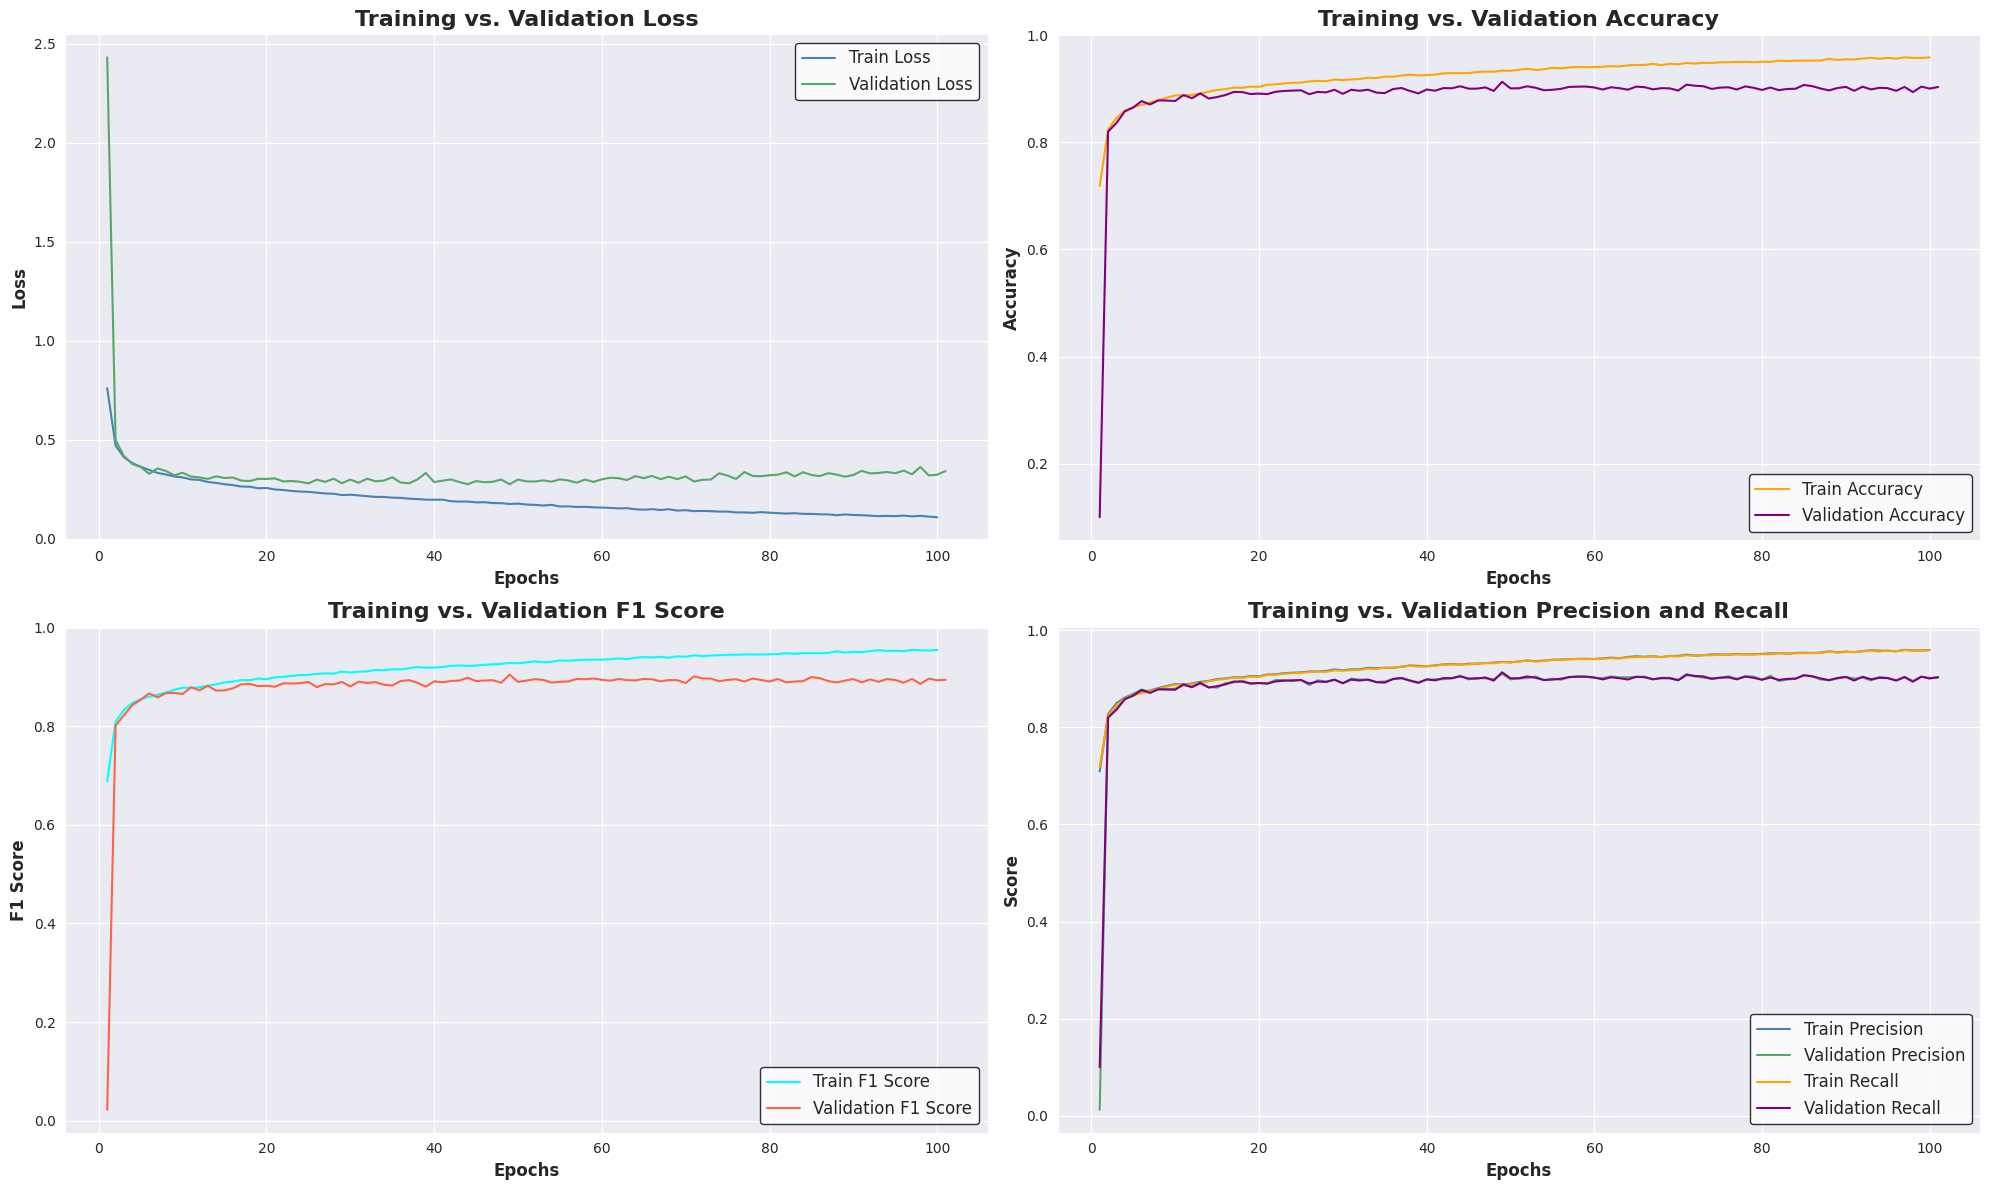

In [10]:

model_monitor(
    train_losses    = callback.train_losses,
    val_losses      = callback.val_losses,
    train_acc       = callback.train_acc,
    val_acc         = callback.val_acc,
    train_f1        = callback.train_f1,
    val_f1          = callback.val_f1,
    train_precision = callback.train_precision,
    val_precision   = callback.val_precision,
    train_recall    = callback.train_recall,
    val_recall      = callback.val_recall,
)

### ***`Attempt for optional embeddings`***
---
- linear
- convolution
- KAN-fourier

In [8]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import Adam
from pytorch_lightning import LightningModule
from torchmetrics import Accuracy, F1Score, Precision, Recall
from einops.layers.torch import Rearrange
from einops import repeat

class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_size, embedding_type):
        super().__init__()
        self.patch_size = patch_size
        self.embedding_type = embedding_type
        
        if embedding_type == 'conv':
            self.proj = nn.Sequential(
                nn.Conv2d(in_channels, embed_size, kernel_size=patch_size, stride=patch_size),
                Rearrange('b e (h) (w) -> b (h w) e')
            )
        elif embedding_type == 'linear':
            self.proj = nn.Sequential(
                Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
                nn.Linear(patch_size * patch_size * in_channels, embed_size)
            )
        else:
            raise ValueError("embedding_type must be 'conv' or 'linear'")

        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) ** 2 + 1, embed_size))

    def forward(self, x):
        b, _, _, _ = x.shape
        x = self.proj(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.positions
        return x
    
    

# Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, mlp_dim, dropout):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_size)
        self.attn = nn.MultiheadAttention(embed_dim=embed_size, num_heads=heads, dropout=dropout)
        self.norm2 = nn.LayerNorm(embed_size)
        self.mlp = nn.Sequential(
            nn.Linear(embed_size, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, embed_size),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = self.norm1(x)
        x = x.permute(1, 0, 2)  # adjust for nn.MultiheadAttention
        attn_output, _ = self.attn(x, x, x)
        attn_output = attn_output.permute(1, 0, 2)  # revert adjustment
        x = self.norm2(x.permute(1, 0, 2) + attn_output)
        x2 = self.mlp(x)
        return x + x2
    
    
    
class ViTConv(pl.LightningModule):
    def __init__(self, img_size=28, patch_size=4, in_channels=1, num_classes=10, embed_size=64, depth=8, heads=4, mlp_dim=128, dropout=0.1, embedding_type='conv'):
        super().__init__()
        self.patch_embedding = PatchEmbedding(img_size, patch_size, in_channels, embed_size, embedding_type)
        self.transformer_blocks = nn.Sequential(
            *[TransformerBlock(embed_size, heads, mlp_dim, dropout) for _ in range(depth)]
        )
        self.to_cls_token = nn.Identity()
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_size),
            nn.Linear(embed_size, num_classes)
        )
        self.train_accuracy = Accuracy(num_classes=num_classes, average='macro', task='multiclass')
        self.val_accuracy = Accuracy(num_classes=num_classes, average='macro', task='multiclass')
        self.test_accuracy = Accuracy(num_classes=num_classes, average='macro', task='multiclass')
        self.train_f1 = F1Score(num_classes=num_classes, average='macro', task='multiclass')
        self.val_f1 = F1Score(num_classes=num_classes, average='macro', task='multiclass')
        self.test_f1 = F1Score(num_classes=num_classes, average='macro', task='multiclass')
        self.train_precision = Precision(num_classes=num_classes, average='macro', task='multiclass')
        self.val_precision = Precision(num_classes=num_classes, average='macro', task='multiclass')
        self.test_precision = Precision(num_classes=num_classes, average='macro', task='multiclass')
        self.train_recall = Recall(num_classes=num_classes, average='macro', task='multiclass')
        self.val_recall = Recall(num_classes=num_classes, average='macro', task='multiclass')
        self.test_recall = Recall(num_classes=num_classes, average='macro', task='multiclass')
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        #print(x.device)
        x = self.patch_embedding(x)
        x = self.transformer_blocks(x)
        x = self.to_cls_token(x[:, 0])
        return self.mlp_head(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = self.train_accuracy(logits, y)
        f1 = self.train_f1(logits, y)
        precision = self.train_precision(logits, y)
        recall = self.train_recall(logits, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_f1', f1, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_precision', precision, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_recall', recall, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = self.val_accuracy(logits, y)
        f1 = self.val_f1(logits, y)
        precision = self.val_precision(logits, y)
        recall = self.val_recall(logits, y)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_step=True, on_epoch=True, prog_bar=True)
        self.log('val_f1', f1, on_step=True, on_epoch=True, prog_bar=True)
        self.log('val_precision', precision, on_step=True, on_epoch=True, prog_bar=True)
        self.log('val_recall', recall, on_step=True, on_epoch=True, prog_bar=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = self.test_accuracy(logits, y)
        f1 = self.test_f1(logits, y)
        precision = self.test_precision(logits, y)
        recall = self.test_recall(logits, y)
        self.log('test_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('test_acc', acc, on_step=True, on_epoch=True, prog_bar=True)
        self.log('test_f1', f1, on_step=True, on_epoch=True, prog_bar=True)
        self.log('test_precision', precision, on_step=True, on_epoch=True, prog_bar=True)
        self.log('test_recall', recall, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=1e-3)


In [19]:
model = ViTConv(embedding_type='linear')
callback = MetricsCallback()
data_module = FashionMNISTDataModule()
trainer = pl.Trainer(
    max_epochs=50,
    precision="16-mixed",
    devices=1 if torch.cuda.is_available() else 1,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    callbacks=[callback]
)
trainer.fit(model, datamodule=data_module)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2024-08-17 12:23:09.422364: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-17 12:23:09.422477: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-17 12:23:09.424609: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-17 12:23:09.439529: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the foll

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [9]:
import torch as th
import torch.nn as nn
from einops.layers.torch import Rearrange
from pytorch_lightning import LightningModule
from torch.optim import Adam


from einops import repeat


# Fourier-based embedding layer
class NaiveFourierKANLayer(th.nn.Module):
    """ link: https://github.com/GistNoesis/FourierKAN/blob/main/fftKAN.py
    """
    def __init__( self, inputdim, outdim, gridsize, addbias=True, smooth_initialization=False):
        super(NaiveFourierKANLayer,self).__init__()
        self.gridsize = gridsize
        self.addbias  = addbias
        self.inputdim = inputdim
        self.outdim   = outdim

        # With smooth_initialization, fourier coefficients are attenuated by the square of their frequency.
        # This makes KAN's scalar functions smooth at initialization.
        # Without smooth_initialization, high gridsizes will lead to high-frequency scalar functions,
        # with high derivatives and low correlation between similar inputs.
        grid_norm_factor = (th.arange(gridsize) + 1)**2 if smooth_initialization else np.sqrt(gridsize)

        #The normalization has been chosen so that if given inputs where each coordinate is of unit variance,
        #then each coordinates of the output is of unit variance
        #independently of the various sizes
        self.fouriercoeffs = th.nn.Parameter( th.randn(2,outdim,inputdim,gridsize) /
                                                (np.sqrt(inputdim) * grid_norm_factor ) )
        if( self.addbias ):
            self.bias  = th.nn.Parameter( th.zeros(1,outdim))

    #x.shape ( ... , indim )
    #out.shape ( ..., outdim)
    def forward(self,x):
        xshp = x.shape
        outshape = xshp[0:-1]+(self.outdim,)
        x = th.reshape(x,(-1,self.inputdim))
        #Starting at 1 because constant terms are in the bias
        k = th.reshape( th.arange(1,self.gridsize+1,device=x.device),(1,1,1,self.gridsize))
        xrshp = th.reshape(x,(x.shape[0],1,x.shape[1],1) )
        #This should be fused to avoid materializing memory
        c = th.cos( k*xrshp )
        s = th.sin( k*xrshp )
        #We compute the interpolation of the various functions defined by their fourier coefficient for each input coordinates and we sum them
        y =  th.sum( c*self.fouriercoeffs[0:1],(-2,-1))
        y += th.sum( s*self.fouriercoeffs[1:2],(-2,-1))
        if( self.addbias):
            y += self.bias
        #End fuse
        '''
        #You can use einsum instead to reduce memory usage
        #It stills not as good as fully fused but it should help
        #einsum is usually slower though
        c = th.reshape(c,(1,x.shape[0],x.shape[1],self.gridsize))
        s = th.reshape(s,(1,x.shape[0],x.shape[1],self.gridsize))
        y2 = th.einsum( "dbik,djik->bj", th.concat([c,s],axis=0) ,self.fouriercoeffs )
        if( self.addbias):
            y2 += self.bias
        diff = th.sum((y2-y)**2)
        print("diff")
        print(diff) #should be ~0
        '''
        y = th.reshape( y, outshape)
        return y

# Patch embedding with optional Fourier, Convolutional, or Linear embedding
class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_size, embedding_type='conv'):
        super().__init__()
        self.patch_size = patch_size  # Used by all embedding types
        self.in_channels = in_channels  # Used by all embedding types
        self.grid_size = patch_size  # Default grid_size to patch_size, adjust if necessary
        self.input_dim = patch_size * patch_size * in_channels  # Compute input_dim from patch_size and in_channels

        if embedding_type == 'conv':
            self.proj = nn.Sequential(
                nn.Conv2d(in_channels, embed_size, kernel_size=patch_size, stride=patch_size),
                Rearrange('b e (h w) -> b (h w) e')
            )
        elif embedding_type == 'linear':
            self.proj = nn.Sequential(
                Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
                nn.Linear(self.input_dim, embed_size)
            )
        elif embedding_type == 'fourier':
            self.proj = nn.Sequential(
                Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
                NaiveFourierKANLayer(patch_size * patch_size * in_channels, embed_size, gridsize=32)  # Adjust gridsize as needed
            )
        else:
            raise ValueError("Invalid embedding_type. Choose 'conv', 'linear', or 'fourier'")

        self.cls_token = nn.Parameter(th.randn(1, 1, embed_size))
        self.positions = nn.Parameter(th.randn((img_size // patch_size) ** 2 + 1, embed_size))

    def forward(self, x):
        b, _, _, _ = x.shape
        x = self.proj(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        x = th.cat([cls_tokens, x], dim=1)
        x += self.positions
        return x


# The rest of the ViTConv model would be defined here, integrating the PatchEmbedding
# and using similar structure and methods as in your previous implementations.

model = ViTConv(embedding_type='fourier')
callback = MetricsCallback()
data_module = FashionMNISTDataModule()
trainer = pl.Trainer(
    max_epochs=50,
    precision="16-mixed",
    devices=1 if torch.cuda.is_available() else 1,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    callbacks=[callback]
)
trainer.fit(model, datamodule=data_module)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2024-08-19 09:18:37.568427: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-19 09:18:37.568502: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-19 09:18:37.569946: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-19 09:18:37.579563: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the foll

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [10]:
trainer.test(model, datamodule=data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_acc_epoch         0.8731245994567871
      test_f1_epoch         0.8619678020477295
     test_loss_epoch        0.49694037437438965
  test_precision_epoch      0.8722451329231262
    test_recall_epoch       0.8731245994567871
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_epoch': 0.49694037437438965,
  'test_acc_epoch': 0.8731245994567871,
  'test_f1_epoch': 0.8619678020477295,
  'test_precision_epoch': 0.8722451329231262,
  'test_recall_epoch': 0.8731245994567871}]

In [ ]:
model_monitor(
    train_losses    = callback.train_losses,
    val_losses      = callback.val_losses,
    train_acc       = callback.train_acc,
    val_acc         = callback.val_acc,
    train_f1        = callback.train_f1,
    val_f1          = callback.val_f1,
    train_precision = callback.train_precision,
    val_precision   = callback.val_precision,
    train_recall    = callback.train_recall,
    val_recall      = callback.val_recall,
)